# Gesture Recognition Using Neural Networks

## 1 Problem Statement
A home electronics company, which manufactures state of the art smart televisions, is looking to develop a feature that recognises five different hand gestures performed by the user via a webcam mounted on the TV, to control it without a remote.

The goal of this deep learning project is to build a neural network that can evaluate the hand gestures and map them to associated commands.

## 2 Project Pipeline
The project is executed as per the following steps:
- Data Reading/Data Understanding
- Data Generator
- Model Building & Training
  - 3D Convolutional Neural Network
  - 2D Convolutional Neural Network + Recurrent Neural Network
- Model Selection

## 3 Data Reading / Data Understanding
Reading and understanding the data

### Importing necessary libraries

In [1]:
import os
import datetime
import random as rn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
from skimage.transform import resize

Setting random seeds so that the results don't vary drastically

In [2]:
rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

### Mounting and extracting data

In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Project_data.zip'

Upon inspection, it is seen that the training data is divided into 2 directories '/content/Project_data/train' and '/content/Project_data/val'. Each subdirectory of 'train' and 'val' contains 30 frames of videos of people making hand gestures. Videos either have dimensions of 360x360 or 120x160.

Each row of each CSV file represents 1 video and contains 3 main pieces of information: the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

## 4 Data Generator

The data generator, defined using the following two functions, reads and preprocesses the images as they are of 2 different dimensions and packages them into batches of video frames for further processing by Tensorflow.

### Defining the data generator

In [5]:
# This function generates batches of videos given a folder list, a batch size and some video specifications
def generator(source_path,folder_list,batch_size,frames,len_):
  while True:  
    folder_list = np.random.permutation(folder_list)
    L = len(folder_list)
    batch_start = 0
    batch_end = batch_size
    
    while batch_start < L:
      batch_data = np.zeros((batch_size,frames,len_,len_,3))
      batch_labels = np.zeros((batch_size,5))
      
      for i in range(batch_end-batch_start):
        folder_name = folder_list[batch_start:batch_end][i]
        batch_data[i,:,:,:,:],batch_labels[i,:] = process_folder(source_path,folder_name,frames,len_)
      
      batch_start = batch_end
      batch_end = min(batch_end+batch_size,L)
      yield batch_data,batch_labels

In [6]:
# This function processes the images in a folder and returns video data and a video label to update the batch
def process_folder(source_path,folder_name,frames,len_):
  fnames = os.listdir(source_path+'/'+folder_name.split(';')[0])
  video_data = np.zeros((frames,len_,len_,3))
  video_label = np.zeros(5)
  
  # Reading the image, cropping, resizing and normalising
  for i,fname in enumerate(fnames[::int(30/frames)]):
    image = imread(source_path+'/'+folder_name.split(';')[0]+'/'+fname)
    if image.shape[0] == 120:
      image = image[:,20:140,:]
    image = resize(image,(len_,len_,))
    video_data[i,:,:,0] = (image[:,:,0] - image[:,:,0].min())/(image[:,:,0].max() - image[:,:,0].min())
    video_data[i,:,:,1] = (image[:,:,1] - image[:,:,1].min())/(image[:,:,1].max() - image[:,:,1].min())
    video_data[i,:,:,2] = (image[:,:,2] - image[:,:,2].min())/(image[:,:,2].max() - image[:,:,2].min())

  video_label[int(folder_name.split(';')[2])] = 1
  
  return video_data,video_label

### Generating paths and lists of training and validation data

In [7]:
# Defining paths of training and validation data
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'

# Generating lists of training and validation images
train_list = open('/content/Project_data/train.csv').readlines()
val_list = open('/content/Project_data/val.csv').readlines()

### Visualising some images from a sample batch

A sample of images from a batch are visualised below to test the data generator.

In [8]:
import matplotlib.pyplot as plt

In [9]:
# Creating a data generator for the training data with batch_size = 8, frames = 3 and len_ = 180
gen = generator(train_path,train_list,8,3,180)

In [10]:
# Viewing images
batch_data,batch_labels = next(gen)
gen.close()

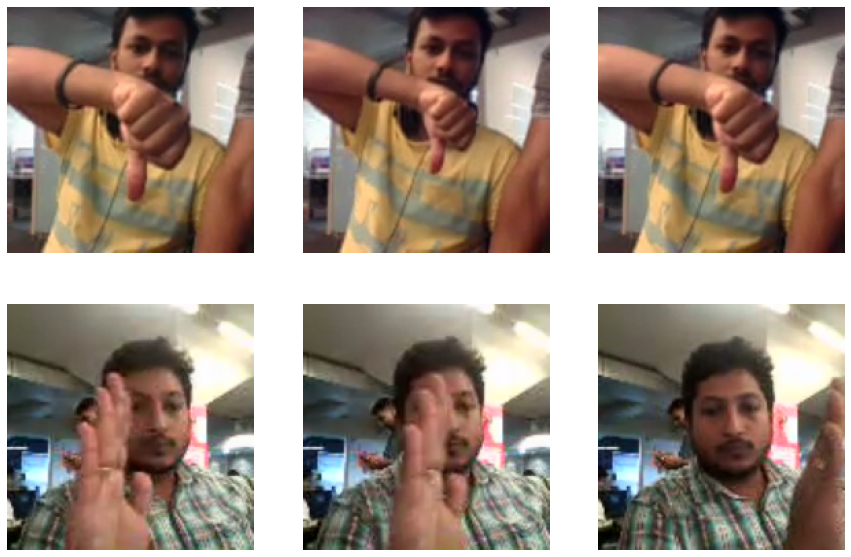

In [11]:
fig = plt.figure(figsize=(15,10))
for i in range(3):
  ax = fig.add_subplot(2,3,i+1)
  ax.imshow(batch_data[0,i,:,:,:])
  ax.axis('off')
  ax = fig.add_subplot(2,3,i+4)
  ax.imshow(batch_data[6,i,:,:,:])
  ax.axis('off')

In [12]:
# Viewing batch labels
print('Video 1 Label:',batch_labels[0])
print('Video 7 Label:',batch_labels[6])

Video 1 Label: [0. 0. 0. 1. 0.]
Video 7 Label: [0. 1. 0. 0. 0.]


Thus, the data generator is generating batches and corresponding labels as expected.

## 5 Model Building & Training
The model will be designed with the goals of maximising accuracy and minimising the number of parameters so that it can fit in the memory of the webcam. The following 2 architectures will be trained and evaluated for this purpose:
- 3D Convolutional Neural Network
- 2D Convolutional Neural Network + Recurrent Neural Network

### Importing libraries, defining functions and initialising variables

In [13]:
# Importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPool2D, TimeDistributed, GRU

In [14]:
# Writing a function to calculate 'steps_per_epoch' and 'validation_steps' to specify the number of next() calls to be made during model training
def compute_steps(num_train_sequences, num_val_sequences, batch_size):
  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
  
  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  
  return steps_per_epoch,validation_steps

In [15]:
# Writing a function to generate a list of callbacks
def callbacks_list(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_name):
      os.mkdir(model_name)
          
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
  
  callbacks_list_ = [checkpoint, LR]

  return callbacks_list_

In [16]:
def plot(history,num_epochs):
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(num_epochs)

  fig = plt.figure(figsize=(18, 6))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(epochs_range, acc, label='Training Accuracy')
  ax.plot(epochs_range, val_acc, label='Validation Accuracy')
  ax.legend(loc='lower right')
  ax.set_title('Training and Validation Accuracy')

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(epochs_range, loss, label='Training Loss')
  ax.plot(epochs_range, val_loss, label='Validation Loss')
  ax.legend(loc='upper right')
  ax.set_title('Training and Validation Loss')
  fig.show()

In [17]:
curr_dt_time = datetime.datetime.now()

num_train_sequences = len(train_list)
print('Number of training sequences:', num_train_sequences)
num_val_sequences = len(val_list)
print('Number of validation sequences:', num_val_sequences)

Number of training sequences: 663
Number of validation sequences: 100


In [18]:
# Initialising parameters
batch_size = 32
frames = 15
len_ = 120
num_epochs = 10

In [19]:
# Creating the 'train_generator' and 'val_generator', which will be used for fitting the model
train_generator = generator(train_path,train_list,batch_size,frames,len_)
val_generator = generator(val_path,val_list,batch_size,frames,len_)

# Calculating the steps per epoch and validation steps
steps_per_epoch,validation_steps = compute_steps(num_train_sequences, num_val_sequences, batch_size)

# Generating the list of callbacks
callbacks_list_ = callbacks_list(curr_dt_time)

### 5.1 Model 1: Architecture = 3D CNN
Model 1 is created with two 3D convolutional layers and 2 dense layers.

In [ ]:
# Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(frames,len_,len_,3)))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.7629 - categorical_accuracy: 0.2158
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.76286-0.21577-1.22597-0.42969.h5
21/21 [==============================] - 140s 6s/step - loss: 1.7629 - categorical_accuracy: 0.2158 - val_loss: 1.2260 - val_categorical_accuracy: 0.4297 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.4646 - categorical_accuracy: 0.3140
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.46465-0.31399-1.08338-0.25000.h5
21/21 [==============================] - 142s 7s/step - loss: 1.4646 - categorical_accuracy: 0.3140 - val_loss: 1.0834 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.2465 - categorical_accuracy: 0.4524
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.24648-0.45238-0.96689-0.38281.h5
21/21 [==============

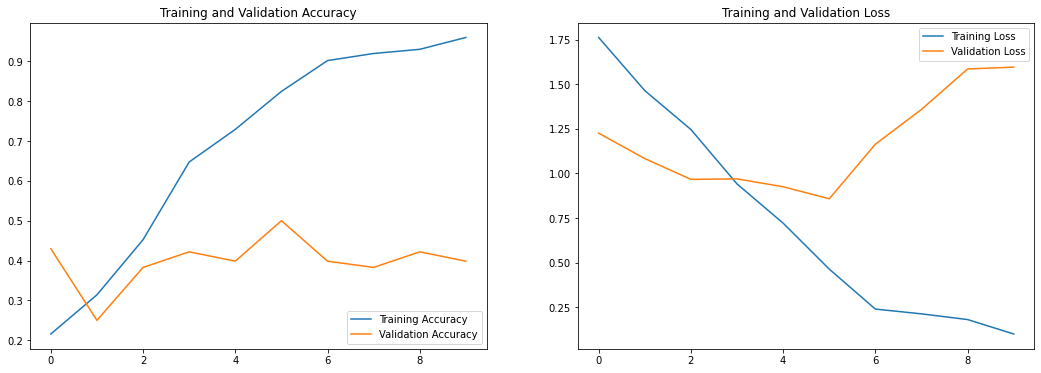

In [ ]:
plot(history,num_epochs)

### 5.2 Model 2: Architecture = 3D CNN
Model 2 is created with an additional 3D CNN layer because the validation loss of model 1 starts increasing after a few epochs.

In [ ]:
# Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(frames,len_,len_,3)))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(128, kernel_size=(1,3,3), activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 2, 26, 26, 128)    73856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 2, 13, 13, 128)  

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.7209 - categorical_accuracy: 0.1964
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.72089-0.19643-1.24246-0.17188.h5
21/21 [==============================] - 136s 7s/step - loss: 1.7209 - categorical_accuracy: 0.1964 - val_loss: 1.2425 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.5457 - categorical_accuracy: 0.2366
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.54571-0.23661-1.16597-0.19531.h5
21/21 [==============================] - 127s 6s/step - loss: 1.5457 - categorical_accuracy: 0.2366 - val_loss: 1.1660 - val_categorical_accuracy: 0.1953 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.4588 - categorical_accuracy: 0.3363
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.45881-0.33631-1.06161-0.33594.h5
21/21 [==============

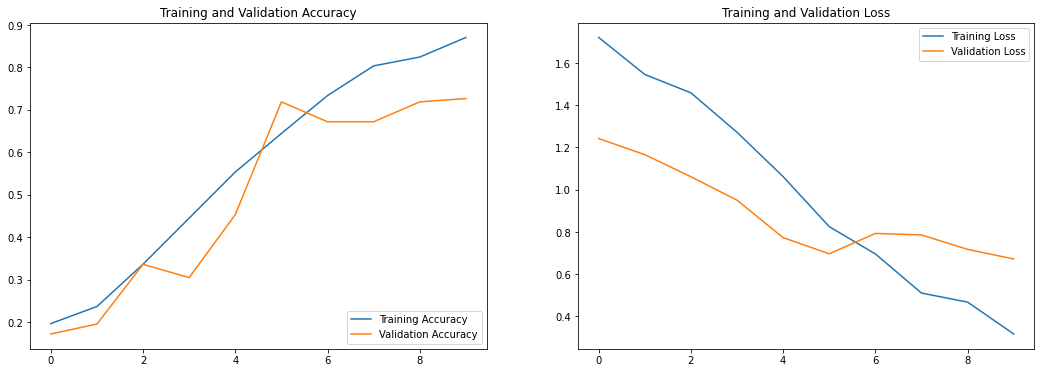

In [ ]:
plot(history,num_epochs)

### 5.3 Model 3: Architecture = 3D CNN
Model 3 is created with a dropout layer to introduce regularization and counter overfitting in model 2.

In [ ]:
# Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(frames,len_,len_,3)))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(128, kernel_size=(1,3,3), activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 6, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 2, 26, 26, 128)    73856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 13, 13, 128)  

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6032 - categorical_accuracy: 0.2366
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.60321-0.23661-1.20748-0.18750.h5
21/21 [==============================] - 138s 7s/step - loss: 1.6032 - categorical_accuracy: 0.2366 - val_loss: 1.2075 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.4052 - categorical_accuracy: 0.3497
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.40518-0.34970-1.01083-0.36719.h5
21/21 [==============================] - 129s 6s/step - loss: 1.4052 - categorical_accuracy: 0.3497 - val_loss: 1.0108 - val_categorical_accuracy: 0.3672 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.1260 - categorical_accuracy: 0.5327
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.12596-0.53274-0.77770-0.52344.h5
21/21 [==============

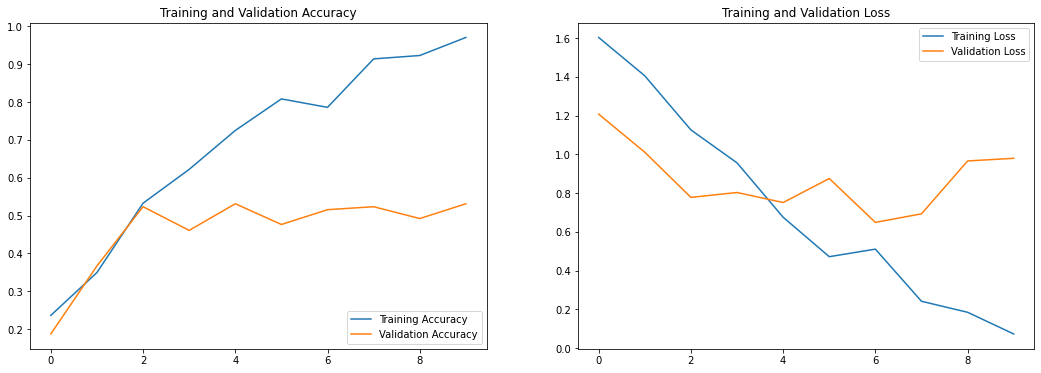

In [ ]:
plot(history,num_epochs)

### 5.4 Model 4: Architecture = 3D CNN
Model 4 contains an extra 3D CNN layer right after the first layer of model 3 and no dropout layer because it resulted in lower validation accuracy.

In [ ]:
# Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(frames,len_,len_,3)))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(128, kernel_size=(1,3,3), activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 5, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 3, 56, 56, 64)     110656    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_11 (Conv3D)          (None, 1, 26, 26, 128)   

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.5526 - categorical_accuracy: 0.2307
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.55258-0.23065-1.17616-0.23438.h5
21/21 [==============================] - 142s 6s/step - loss: 1.5526 - categorical_accuracy: 0.2307 - val_loss: 1.1762 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.4181 - categorical_accuracy: 0.3661
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.41814-0.36607-1.04133-0.35156.h5
21/21 [==============================] - 142s 7s/step - loss: 1.4181 - categorical_accuracy: 0.3661 - val_loss: 1.0413 - val_categorical_accuracy: 0.3516 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.2910 - categorical_accuracy: 0.4122
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.29100-0.41220-0.93517-0.40625.h5
21/21 [==============

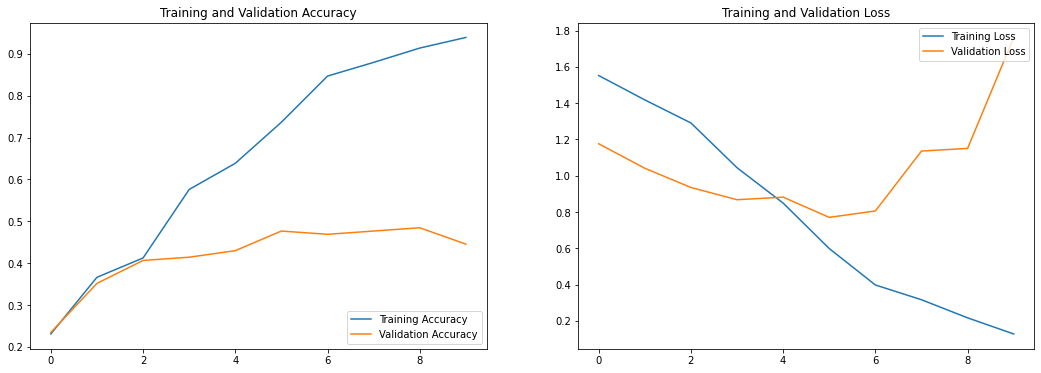

In [ ]:
plot(history,num_epochs)

### 5.5 Model 5: Architecture = 3D CNN
Model 5 is an experiment with the extra 3D CNN layer added after the second layer.

In [ ]:
# Creating the model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(frames,len_,len_,3)))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPool3D(pool_size=2))

model.add(Conv3D(128, kernel_size=(1,3,3), activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 59, 59, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 4, 57, 57, 64)     55360     
                                                                 
 conv3d_14 (Conv3D)          (None, 2, 55, 55, 64)     110656    
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 1, 27, 27, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 1, 25, 25, 128)   

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.5915 - categorical_accuracy: 0.2098
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.59154-0.20982-1.21406-0.17969.h5
21/21 [==============================] - 135s 7s/step - loss: 1.5915 - categorical_accuracy: 0.2098 - val_loss: 1.2141 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.5397 - categorical_accuracy: 0.2366
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.53967-0.23661-1.18742-0.35156.h5
21/21 [==============================] - 128s 6s/step - loss: 1.5397 - categorical_accuracy: 0.2366 - val_loss: 1.1874 - val_categorical_accuracy: 0.3516 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.3797 - categorical_accuracy: 0.3839
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.37974-0.38393-0.95424-0.35938.h5
21/21 [==============

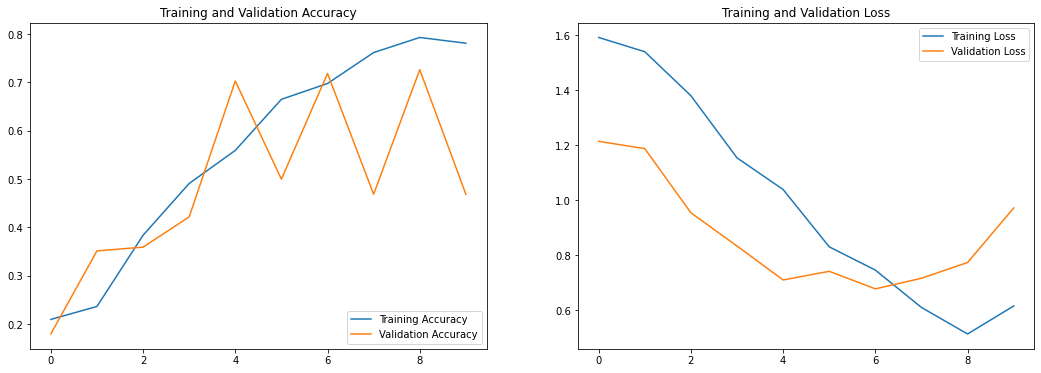

In [ ]:
plot(history,num_epochs)

### 5.6 Model 6: Architecture = 2D CNN + RNN
Model 6 is created with two time-distributed 2D convolutional layers and 1 GRU layer.

In [ ]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 28, 28, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50176)       

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.9095 - categorical_accuracy: 0.1845
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.90954-0.18452-1.27688-0.17188.h5
21/21 [==============================] - 139s 7s/step - loss: 1.9095 - categorical_accuracy: 0.1845 - val_loss: 1.2769 - val_categorical_accuracy: 0.1719 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.6422 - categorical_accuracy: 0.1801
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.64223-0.18006-1.25551-0.21094.h5
21/21 [==============================] - 145s 7s/step - loss: 1.6422 - categorical_accuracy: 0.1801 - val_loss: 1.2555 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.5982 - categorical_accuracy: 0.2009
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.59820-0.20089-1.27421-0.14062.h5
21/21 [==============

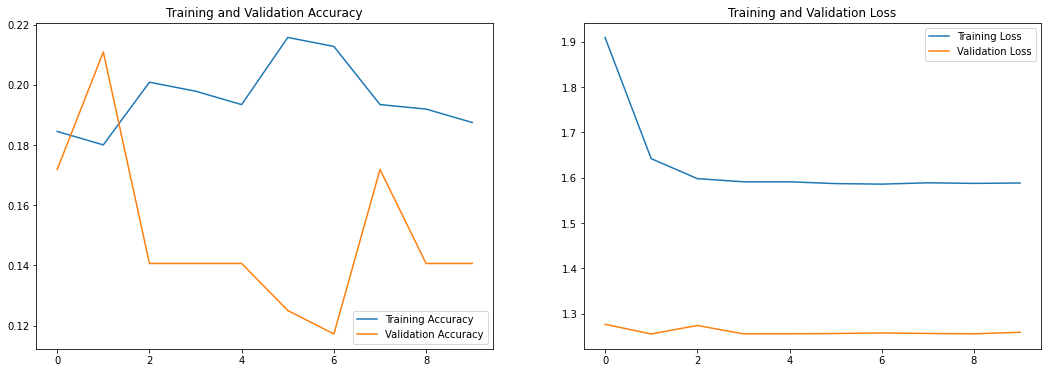

In [ ]:
plot(history,num_epochs)

### 5.7 Model 7: Architecture = 2D CNN + RNN
Model 7 is created by adding an additional time-distributed 2D convolutional layer to model 6.

In [ ]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 15, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 28, 28, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 26, 26, 128) 

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6155 - categorical_accuracy: 0.1979
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.61551-0.19792-1.22424-0.24219.h5
21/21 [==============================] - 135s 7s/step - loss: 1.6155 - categorical_accuracy: 0.1979 - val_loss: 1.2242 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.3944 - categorical_accuracy: 0.4003
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.39443-0.40030-1.08287-0.28906.h5
21/21 [==============================] - 142s 7s/step - loss: 1.3944 - categorical_accuracy: 0.4003 - val_loss: 1.0829 - val_categorical_accuracy: 0.2891 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.0724 - categorical_accuracy: 0.5759
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.07241-0.57589-0.87361-0.47656.h5
21/21 [==============

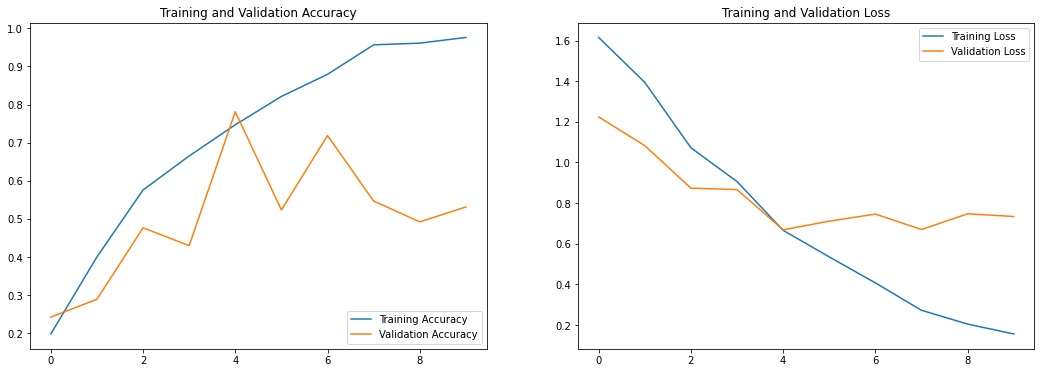

In [ ]:
plot(history,num_epochs)

### 5.8 Model 8: Architecture = 2D CNN + RNN
Model 8 is created by adding a dropout layer to model 7 right before the GRU layer.

In [ ]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.25))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 28, 28, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 26, 26, 128) 

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6038 - categorical_accuracy: 0.2098
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.60378-0.20982-1.18592-0.27344.h5
21/21 [==============================] - 137s 7s/step - loss: 1.6038 - categorical_accuracy: 0.2098 - val_loss: 1.1859 - val_categorical_accuracy: 0.2734 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.3467 - categorical_accuracy: 0.4286
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.34670-0.42857-1.01639-0.58594.h5
21/21 [==============================] - 136s 7s/step - loss: 1.3467 - categorical_accuracy: 0.4286 - val_loss: 1.0164 - val_categorical_accuracy: 0.5859 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.0933 - categorical_accuracy: 0.5848
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-1.09332-0.58482-0.81424-0.48438.h5
21/21 [==============

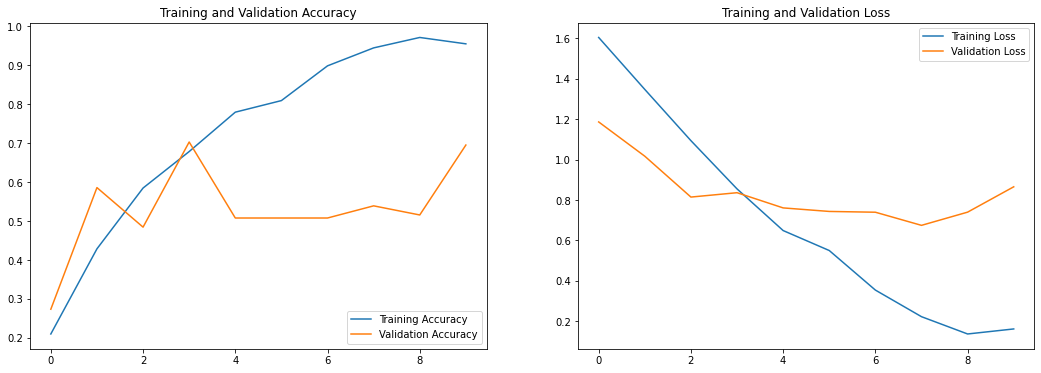

In [ ]:
plot(history,num_epochs)

### 5.9 Model 9: Architecture = 2D CNN + RNN
Model 9 is created by adding batch normalization to model 7.

In [ ]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 59, 59, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 28, 28, 64)  

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.5281 - categorical_accuracy: 0.4286
Epoch 1: saving model to model_init_2023-02-1313_44_35.046205/model-00001-1.52808-0.42857-1.64198-0.19531.h5
21/21 [==============================] - 143s 7s/step - loss: 1.5281 - categorical_accuracy: 0.4286 - val_loss: 1.6420 - val_categorical_accuracy: 0.1953 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.0049 - categorical_accuracy: 0.5952
Epoch 2: saving model to model_init_2023-02-1313_44_35.046205/model-00002-1.00492-0.59524-1.51070-0.24219.h5
21/21 [==============================] - 125s 6s/step - loss: 1.0049 - categorical_accuracy: 0.5952 - val_loss: 1.5107 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.9215 - categorical_accuracy: 0.6280
Epoch 3: saving model to model_init_2023-02-1313_44_35.046205/model-00003-0.92148-0.62798-1.56124-0.25000.h5
21/21 [==============

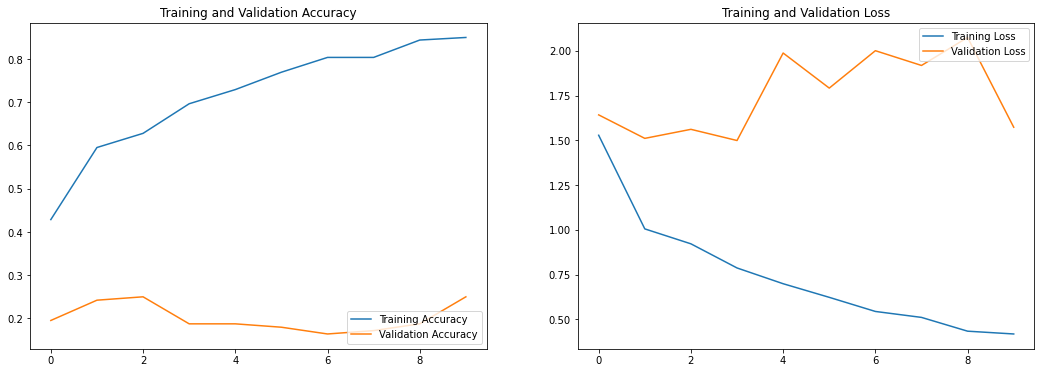

In [ ]:
plot(history,num_epochs)

### 5.10 Model 10: Architecture = 2D CNN + RNN
Model 10 is created by adding an additional CNN layer before the GRU layer in model 7.

In [ ]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [ ]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Viewing a summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 28, 28, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 26, 26, 128)  7

In [ ]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6173 - categorical_accuracy: 0.2262
Epoch 1: saving model to model_init_2023-02-1318_00_45.687738/model-00001-1.61726-0.22619-1.24706-0.35938.h5
21/21 [==============================] - 146s 6s/step - loss: 1.6173 - categorical_accuracy: 0.2262 - val_loss: 1.2471 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.5338 - categorical_accuracy: 0.2589
Epoch 2: saving model to model_init_2023-02-1318_00_45.687738/model-00002-1.53380-0.25893-1.09122-0.28125.h5
21/21 [==============================] - 129s 6s/step - loss: 1.5338 - categorical_accuracy: 0.2589 - val_loss: 1.0912 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.2799 - categorical_accuracy: 0.4673
Epoch 3: saving model to model_init_2023-02-1318_00_45.687738/model-00003-1.27995-0.46726-0.90726-0.46875.h5
21/21 [==============

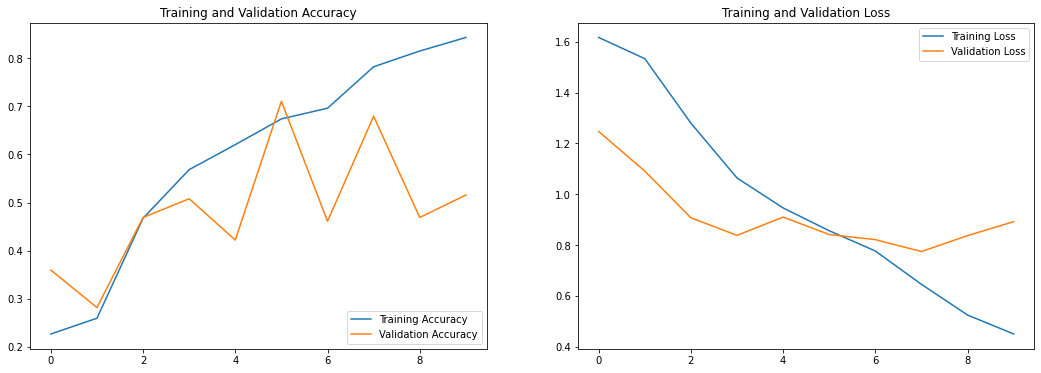

In [ ]:
plot(history,num_epochs)

### 5.11 Model 11: Architecture = 2D CNN + RNN
Model 11 uses images of size 160x160 in model 7, which is the best performing model.

In [18]:
# Initialising parameters
batch_size = 32
frames = 15
len_ = 160
num_epochs = 10

In [19]:
# Creating the 'train_generator' and 'val_generator', which will be used for fitting the model
train_generator = generator(train_path,train_list,batch_size,frames,len_)
val_generator = generator(val_path,val_list,batch_size,frames,len_)

# Calculating the steps per epoch and validation steps
steps_per_epoch,validation_steps = compute_steps(num_train_sequences, num_val_sequences, batch_size)

# Generating the list of callbacks
callbacks_list_ = callbacks_list(curr_dt_time)

In [20]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [21]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
# Viewing a summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 158, 158, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 79, 79, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 77, 77, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 38, 38, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 36, 36, 128)  7

In [23]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6973 - categorical_accuracy: 0.1920
Epoch 1: saving model to model_init_2023-02-1406_37_18.098616/model-00001-1.69727-0.19196-1.21899-0.17969.h5
21/21 [==============================] - 175s 8s/step - loss: 1.6973 - categorical_accuracy: 0.1920 - val_loss: 1.2190 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.4606 - categorical_accuracy: 0.3542
Epoch 2: saving model to model_init_2023-02-1406_37_18.098616/model-00002-1.46057-0.35417-0.98304-0.38281.h5
21/21 [==============================] - 163s 8s/step - loss: 1.4606 - categorical_accuracy: 0.3542 - val_loss: 0.9830 - val_categorical_accuracy: 0.3828 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.1484 - categorical_accuracy: 0.5149
Epoch 3: saving model to model_init_2023-02-1406_37_18.098616/model-00003-1.14839-0.51488-0.85955-0.47656.h5
21/21 [==============

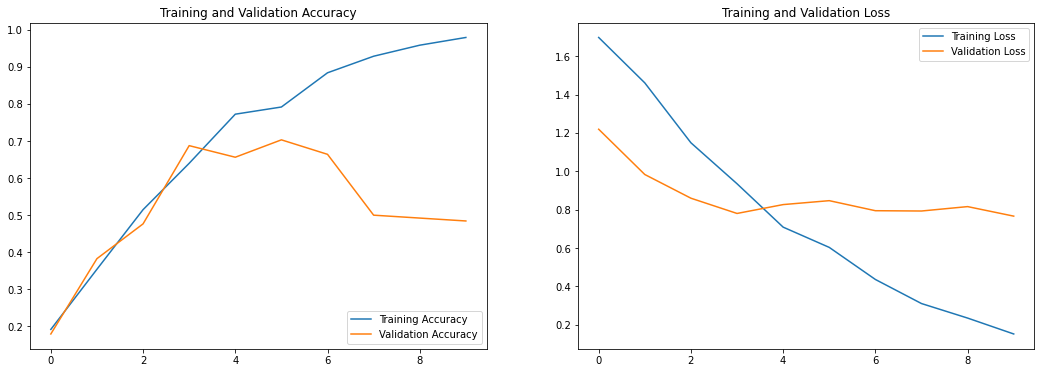

In [24]:
plot(history,num_epochs)

### 5.12 Model 12: Architecture = 2D CNN + RNN
Model 12 uses 30 frames and images of size 160x160 in model 10, which has the lowest number of parameters.

In [25]:
# Initialising parameters
batch_size = 32
frames = 30
len_ = 160
num_epochs = 10

In [26]:
# Creating the 'train_generator' and 'val_generator', which will be used for fitting the model
train_generator = generator(train_path,train_list,batch_size,frames,len_)
val_generator = generator(val_path,val_list,batch_size,frames,len_)

# Calculating the steps per epoch and validation steps
steps_per_epoch,validation_steps = compute_steps(num_train_sequences, num_val_sequences, batch_size)

# Generating the list of callbacks
callbacks_list_ = callbacks_list(curr_dt_time)

In [27]:
# Creating the model
model = Sequential()

model.add(TimeDistributed(Conv2D(32, kernel_size=3, activation='relu'), input_shape=(frames,len_,len_,3)))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Conv2D(256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPool2D(pool_size=2)))

model.add(TimeDistributed(Flatten()))
model.add(GRU(16))
model.add(Dense(5, activation='softmax'))

In [28]:
#Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
# Viewing a summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 30, 158, 158, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 79, 79, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 77, 77, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 38, 38, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 36, 36, 128) 

In [30]:
# Fitting the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
          callbacks=callbacks_list_, validation_data=val_generator, 
          validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


ResourceExhaustedError: ignored

## 6 Model Selection

Loading the final model and making predictions

In [27]:
from tensorflow.keras.models import load_model

In [21]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/model-00005-0.66613-0.74702-0.66864-0.78125.h5')

In [39]:
batch_data,batch_labels = next(val_generator)
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [40]:
# Computing predictions
print(np.argmax(model.predict(batch_data),axis=1))

1/1 [==============================] - 0s 92ms/step
[1 1 0 3 1 0 4 2 3 2 4 1 3 4 0 2 1 1 1 2 2 4 0 4 1 0 0 0 4 0 3 2]
